In [2]:
import sys
sys.path.append('/home/nick/workspace/zoo-aquifer')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import metrics
import seaborn as sns
from utils import viz

### Helper functions

In [3]:
df_norm = pd.read_csv('../data/dynamic_variables_all_normalized.csv', index_col=0, parse_dates=True)
df_norm = df_norm[(df_norm.index >= '1999-10-01') & (df_norm.index <= '2023-10-01')]

In [4]:
# average gw depth across all wells
df_norm['gw_avg'] = df_norm.iloc[:, 2:].mean(axis=1)

### Plot normalized values of average GW depth, Q, and pumping rates

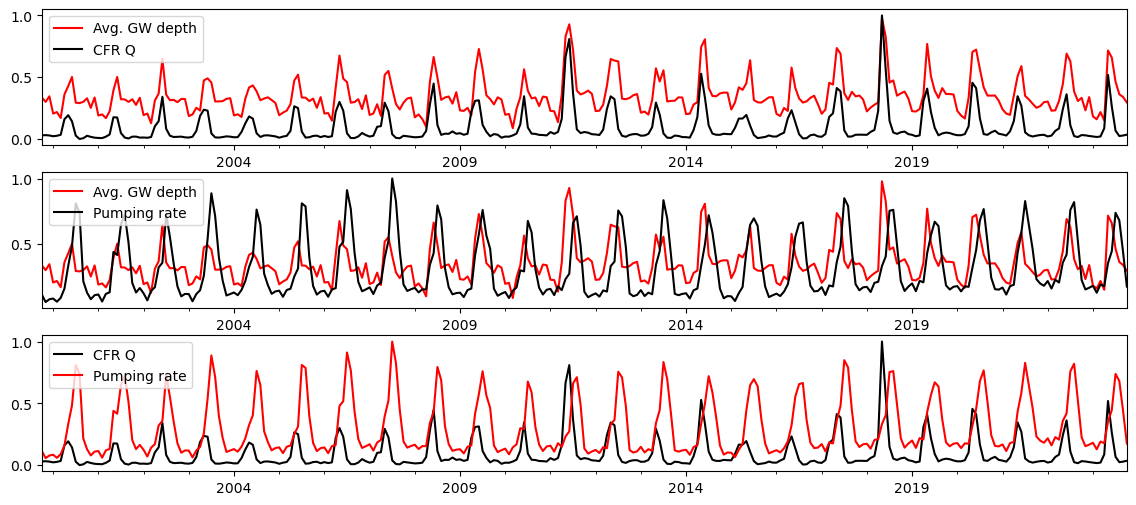

In [5]:
# plot normalized time seris of gw, q, and pumping rate   
fig, ax = plt.subplots(3, 1, figsize=(14, 6))
df_norm['gw_avg'].plot(ax=ax[0], color='red', label='Avg. GW depth')
df_norm['Q'].plot(ax=ax[0], color='black', label='CFR Q')
df_norm['gw_avg'].plot(ax=ax[1], color='red', label='Avg. GW depth')
df_norm['pumping_rate'].plot(ax=ax[1], color='black', label='Pumping rate')
df_norm['Q'].plot(ax=ax[2], color='black', label='CFR Q')
df_norm['pumping_rate'].plot(ax=ax[2], color='red', label='Pumping rate')
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[2].legend(loc='upper left')

### Remove trend and seasonality of normalized Q from groundwater signal

In [6]:
res = STL(df_norm['Q'], seasonal=13, period=12, seasonal_deg=0, trend_deg=0, trend=57, robust=True).fit()
# res = seasonal_decompose(df_norm['Q'], model='additive', period=12)

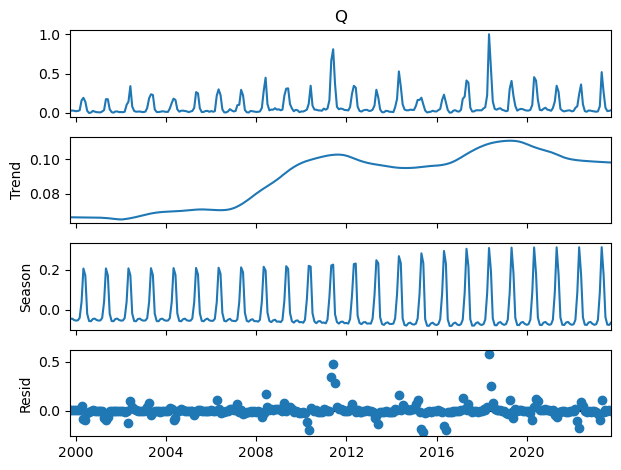

In [7]:
res.plot()
plt.show()

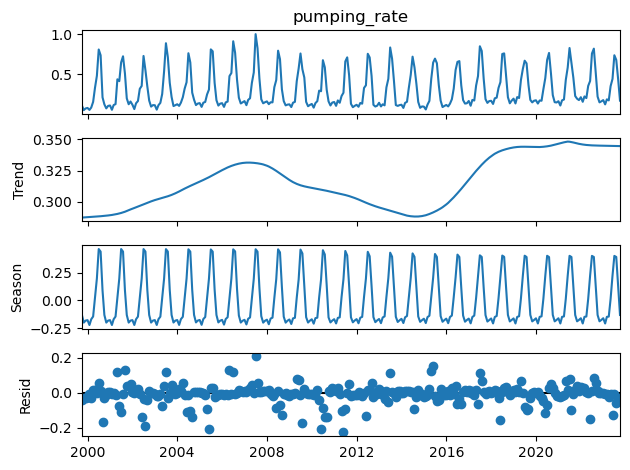

In [8]:
res_pr = STL(df_norm['pumping_rate'], seasonal=13, period=12, seasonal_deg=0, trend_deg=0, trend=57, robust=True).fit()
res_pr.plot()
plt.show()

In [9]:
df_corr3 = df_norm.drop(columns=['Q', 'pumping_rate', 'gw_avg'])
df_corr3 = df_corr3.sub(res.trend, axis=0)#.sub(res.seasonal, axis=0)
# df_corr3 = df_corr3.sub(df_norm['Q'], axis=0)

In [9]:
df_corr3.apply(lambda col: col.corr(df_norm['pumping_rate']))

67037     0.214861
69402     0.388668
151061    0.415664
151101    0.303310
151143    0.396577
151161    0.417152
151179    0.388282
151188    0.320860
151189    0.601073
151190    0.567627
151191    0.361489
157208    0.365922
157211    0.414209
209148    0.366741
209254    0.197627
209255    0.394716
dtype: float64

In [10]:
df_melt = df_corr3.reset_index().melt(id_vars='index')
df_melt['time'] = pd.to_datetime(df_melt['index'])
df_melt.drop(columns=['index'], inplace=True)

In [11]:
# Melt dataframe
df_trend = df_melt.copy()
df_trend['timestamp'] = df_trend['time'].apply(lambda x: x.timestamp() if pd.notnull(x) else x)

# Group the data by the 'variable' column and apply the 'get_trend' function
trends = df_trend.groupby('variable').apply(viz.get_mk_trend)

# Join the 'trends' DataFrame with the 'df_trend' DataFrame
df_trend = df_trend.join(trends, on='variable')

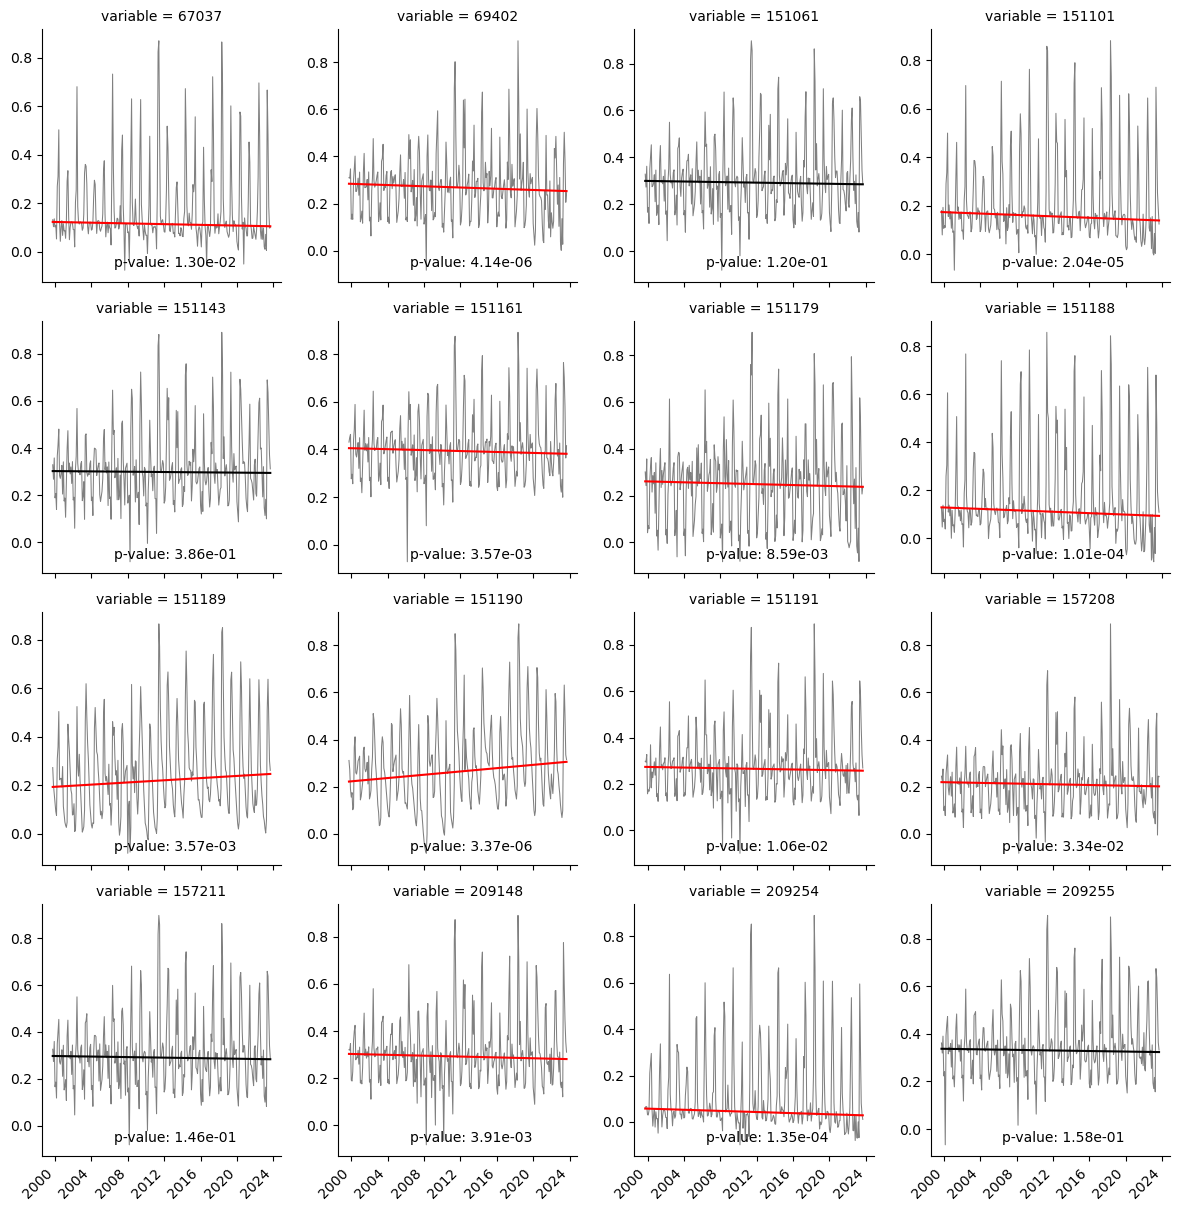

In [12]:
# Create the FacetGrid plot
g = sns.FacetGrid(df_trend, col='variable', col_wrap=4, sharey=False, sharex=True)

# Map the plot_data_and_trendline function to the FacetGrid
g.map_dataframe(viz.plot_data_and_trendline, mann_kendall=True)

# Rotate the x-tick labels on all subplots
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

plt.show()

### Look at trends in groundwater from 2015

In [13]:
mask = (df_norm.index >= '2014-10-01')
df_recent = df_norm.loc[mask]
df_recent = df_recent.drop(columns=['Q', 'pumping_rate', 'gw_avg'])

In [14]:
df_melt = df_recent.reset_index().melt(id_vars='index')
df_melt['time'] = pd.to_datetime(df_melt['index'])
df_melt.drop(columns=['index'], inplace=True)

In [16]:
# Melt dataframe
df_trend = df_melt.copy()
df_trend['timestamp'] = df_trend['time'].apply(lambda x: x.timestamp() if pd.notnull(x) else x)

# Group the data by the 'variable' column and apply the 'get_trend' function
trends = df_trend.groupby('variable').apply(viz.get_mk_trend)

# Join the 'trends' DataFrame with the 'df_trend' DataFrame
df_trend = df_trend.join(trends, on='variable')

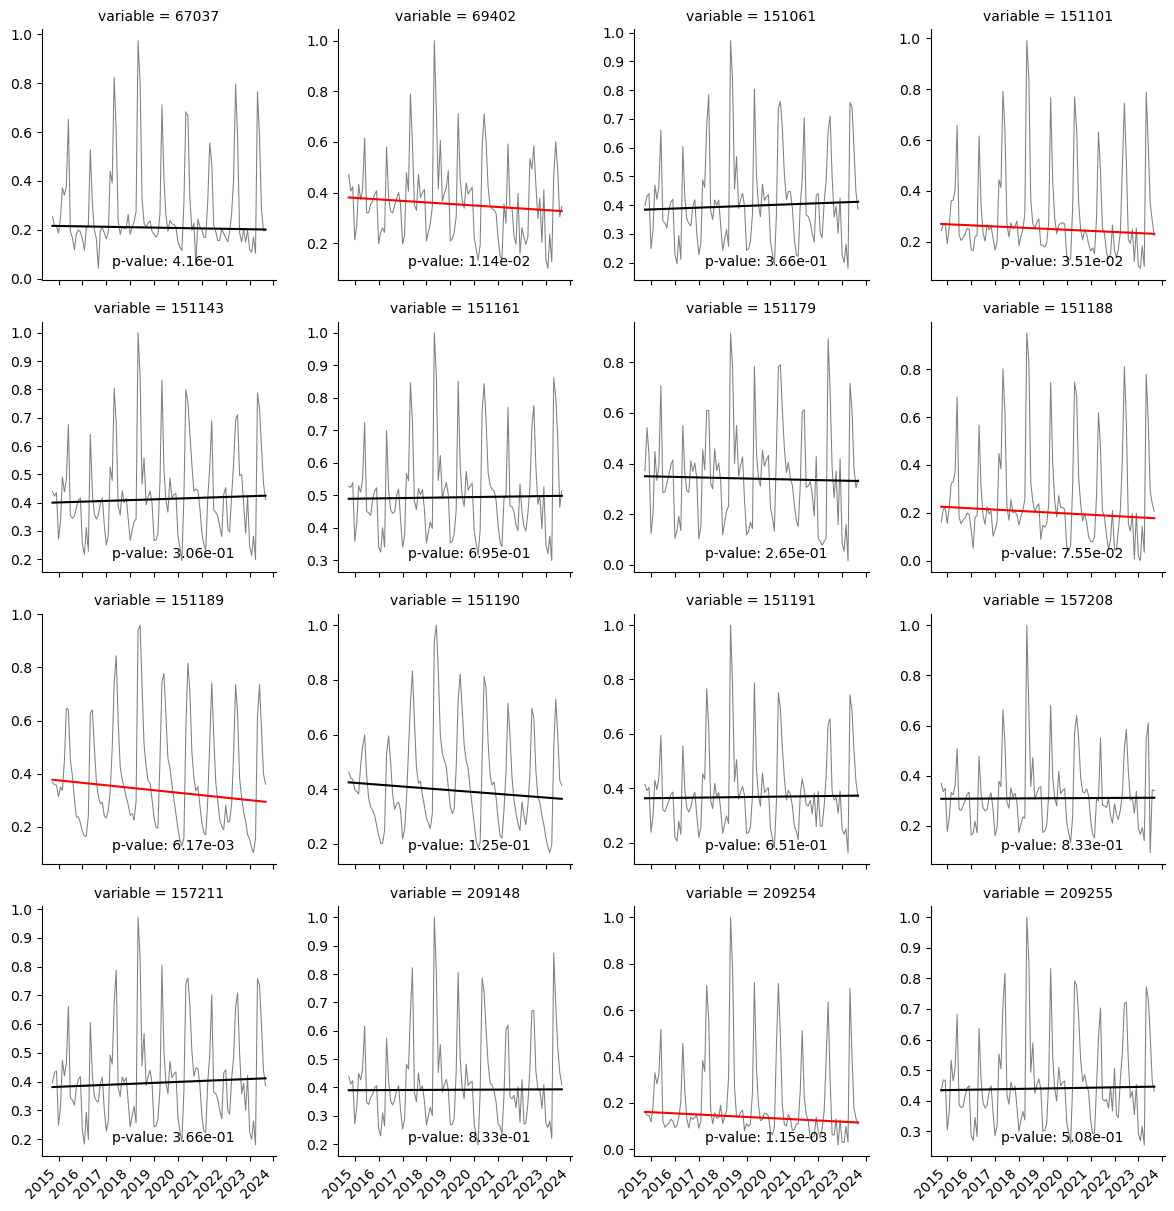

In [18]:
# Create the FacetGrid plot
g = sns.FacetGrid(df_trend, col='variable', col_wrap=4, sharey=False, sharex=True)

# Map the plot_data_and_trendline function to the FacetGrid
g.map_dataframe(viz.plot_data_and_trendline, mann_kendall=True)

# Rotate the x-tick labels on all subplots
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

plt.show()

### Model $\Delta$ groundwater with $\Delta$ Q using MLR 

In [19]:
# calculate difference between time steps
df_diff = df_norm.diff().shift().dropna()

# calculate time lagged cfr values
df_cfr = pd.DataFrame(df_diff['Q'])
for i in range(1, 13):
    cname = 'Q_lag_' + str(i)
    df_cfr[cname] = df_diff['Q'].shift(-i)
df_cfr = df_cfr.dropna()

# get just well data
df_wells = df_diff.iloc[:, 2:-1]
df_wells = df_wells.loc[df_cfr.index]

# train test split
x_train, x_test, y_train, y_test = train_test_split(df_cfr, df_wells, test_size=0.2, random_state=42)
mlr = LinearRegression()

### Plot RMSE values for models using additional time lagged Q values as predictors

In [20]:
df_rmse = pd.DataFrame(index=range(1, 13), columns=y_test.columns)
for i in range(y_test.shape[1]):
    rmse_list = []
    for j in range(1, 13):
        mlr.fit(x_train.iloc[:, :j], y_train.iloc[:, i])
        y_pred = mlr.predict(x_test.iloc[:, :j])
        rmse = np.sqrt(metrics.mean_squared_error(y_test.iloc[:, i], y_pred))
        rmse_list.append(rmse)
    df_rmse[y_test.columns[i]] = rmse_list

Text(0.5, 0, 'Time lag (months)')

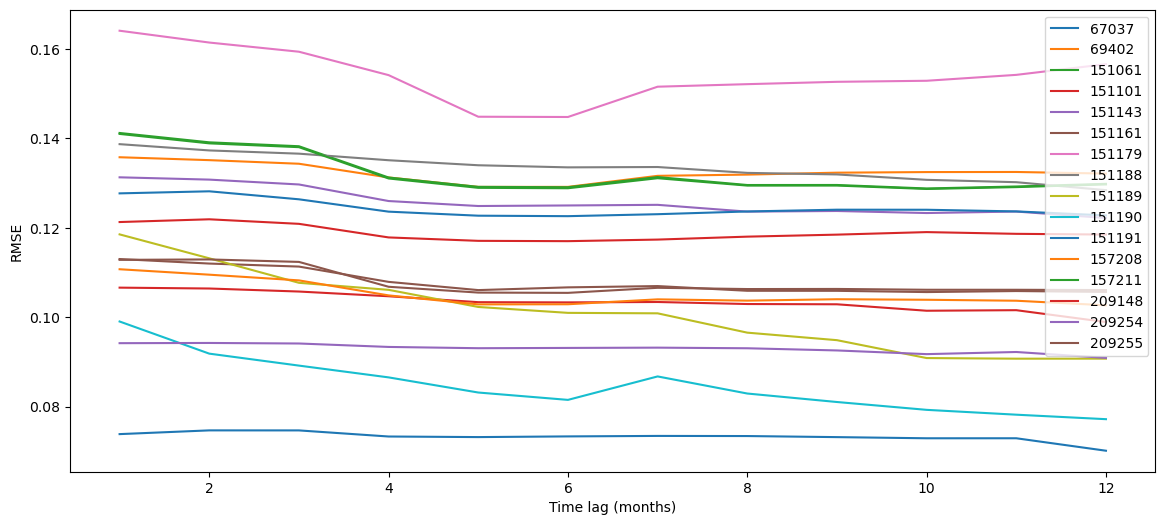

In [21]:
df_rmse.plot(figsize=(14, 6))
plt.ylabel("RMSE")
plt.xlabel("Time lag (months)")

Results suggest that for most wells there is very little advantage to using time-lagged Q values. In addition, from a process perspective, any lagged relationship is likely within the one-month time step, therefore we will only use Q values at time t.  

In [22]:
mlr2 = LinearRegression()
mlr2.fit(df_cfr['Q'].values.reshape(-1, 1), 
         df_wells.iloc[:, 0].values.reshape(-1, 1))
y_pred = mlr2.predict(df_cfr['Q'].values.reshape(-1, 1))
y_pred = pd.Series(y_pred.reshape(-1), index=df_wells.index).shift(-1)
y_corr = df_norm.iloc[:, 2].sub(y_pred.cumsum())

### Plot predicted vs. actual

0.08933174116569191
0.6863108863729653


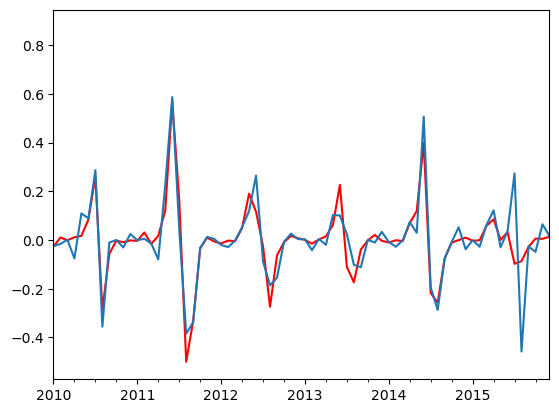

In [23]:
y_pred.shift(1).plot(xlim=('2010-01-01', '2015-12-31'), color='red', label='Predicted GW depth')
df_wells.iloc[:, 0].plot(xlim=('2010-01-01', '2015-12-31'))
print(np.sqrt(metrics.mean_squared_error(df_wells.iloc[1:, 0], y_pred.shift(1).iloc[1:])))
print(metrics.r2_score(df_wells.iloc[1:, 0], y_pred.shift(1).iloc[1:]))

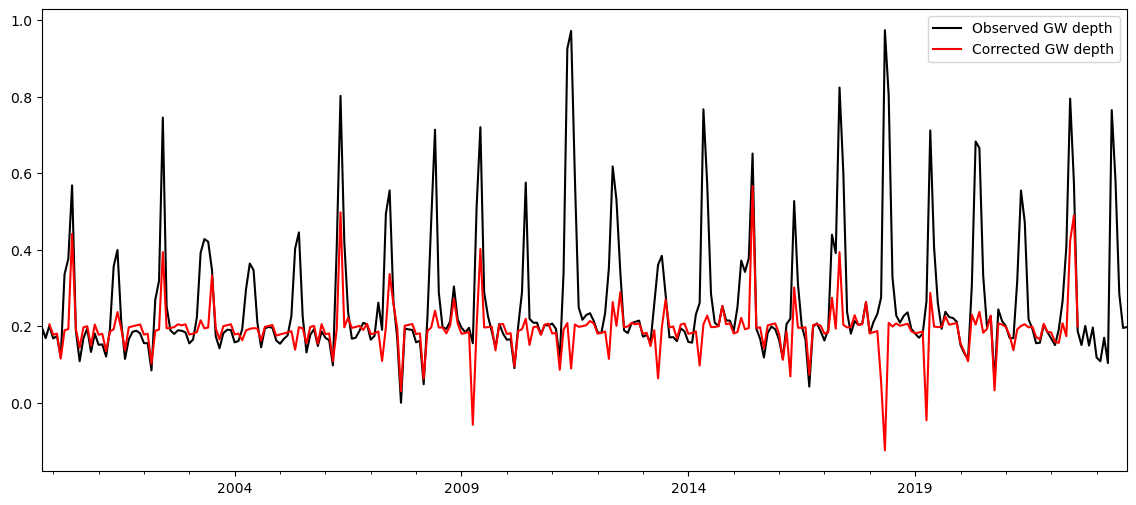

In [24]:
df_norm.iloc[:, 2].plot(figsize=(14, 6), color='black', label='Observed GW depth')
y_corr.dropna().plot(color='red', label='Corrected GW depth')
plt.legend()

This does not seem to be removing full streamflow signal. I will try without normalizing like the original [paper](https://ngwa.onlinelibrary.wiley.com/doi/10.1111/j.1745-6584.2010.00780.x).

In [25]:
df = pd.read_csv('../data/missoula_valley_wells_imputed_qreg.csv', index_col=0, parse_dates=True)

# Clip data
df = df[(df.index >= '1999-10-01') & (df.index <= '2023-09-30')]

# Multiply depths by -1
depth_cols = [i for i in df.columns if not i in ['time', 'Q', 'pumping_rate']]
for col in depth_cols:
    df[col] *= -1

# Calculate difference between time steps
df_diff2 = df.diff().dropna()
df_wells2 = df_diff2.iloc[:, 1:]

# Calculate time lagged cfr values
df_q = pd.DataFrame(df_diff2['Q'])
for i in range(1, 13):
    cname = 'Q_lag_' + str(i)
    df_q[cname] = df_diff2['Q'].shift(-i)

In [26]:
df_corr = df.iloc[:, 1:].copy()

# Clip Q data to specified lag
lag = 1
df_q = df_q.iloc[:, :lag+1].dropna()

# Make sure indices are the same across all dataframes
df_wells2 = df_wells2.loc[df_q.index]
df_corr = df_corr.loc[df_q.index]

for well in range(df_wells2.iloc[:, 1:].shape[1]+1):
    mlr3 = LinearRegression()
    mlr3.fit(df_q.values, 
            df_wells2.iloc[:, well].values.reshape(-1, 1))
    y_pred2 = mlr3.predict(df_q.values)
    y_pred2 = pd.Series(y_pred2.reshape(-1), index=df_wells2.index).shift(-1)
    y_corr2 = df.loc[df_q.index].iloc[:, well+1].sub(1*y_pred2.cumsum())
    df_corr.iloc[:, well] = y_corr2

<Axes: xlabel='time'>

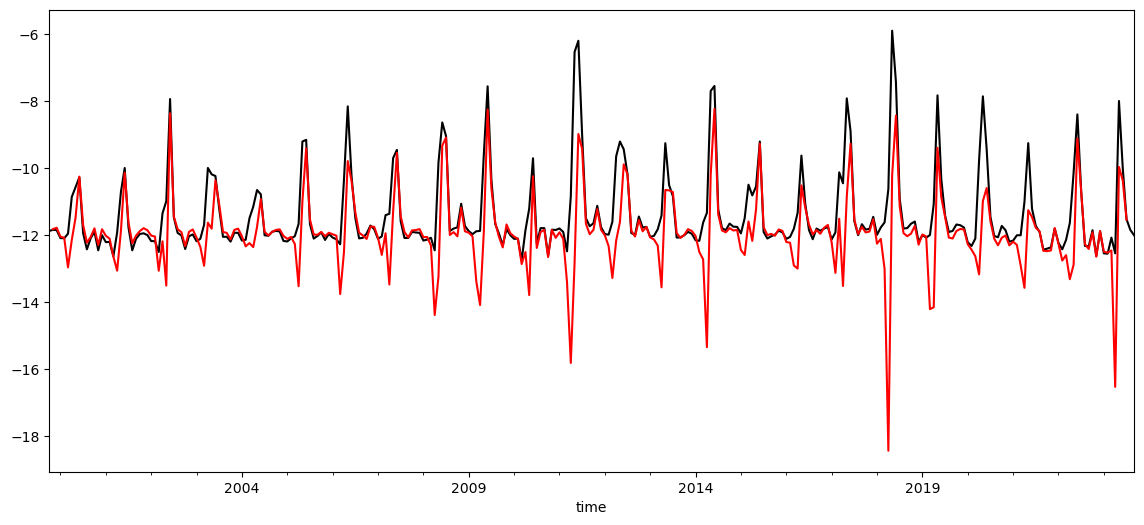

In [27]:
df['209254'].plot(figsize=(14, 6), color='black', label='Observed GW depth')
df_corr['209254'].plot(figsize=(14, 6), color='red', label='Corrected GW depth')

Some removal, but less than I would expect.

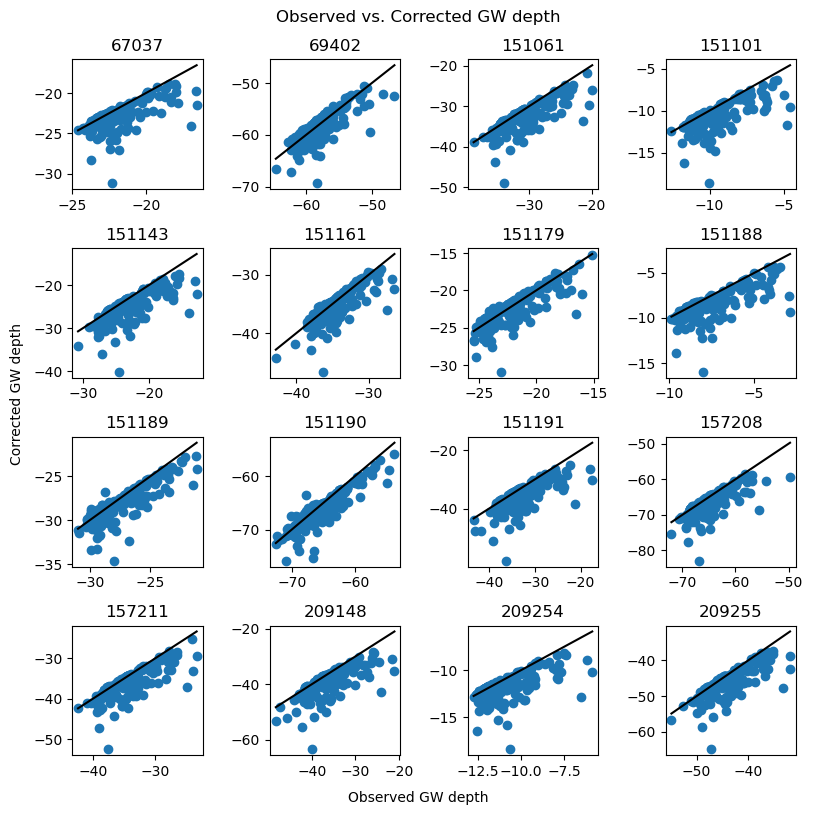

In [28]:
fig, ax = plt.subplots(4, 4, figsize=(8, 8))
for i, well_id in enumerate(df_corr.columns):
    ax.flatten()[i].plot(df.loc[df_q.index][well_id], df_corr[well_id], 'o')
    ax.flatten()[i].plot([df.loc[df_q.index][well_id].min(), df[well_id].max()], [df[well_id].min(), df[well_id].max()], 'k-')
    ax.flatten()[i].title.set_text(well_id)
#ax[3, 3].set_visible(False)
fig.suptitle('Observed vs. Corrected GW depth')
fig.text(0.5, -0.01, 'Observed GW depth', ha='center')
fig.text(-0.01, 0.5, 'Corrected GW depth', va='center', rotation='vertical')
plt.tight_layout()
plt.show()

Corrections are generally in one direction (deeper depths) with the exception of '150967'

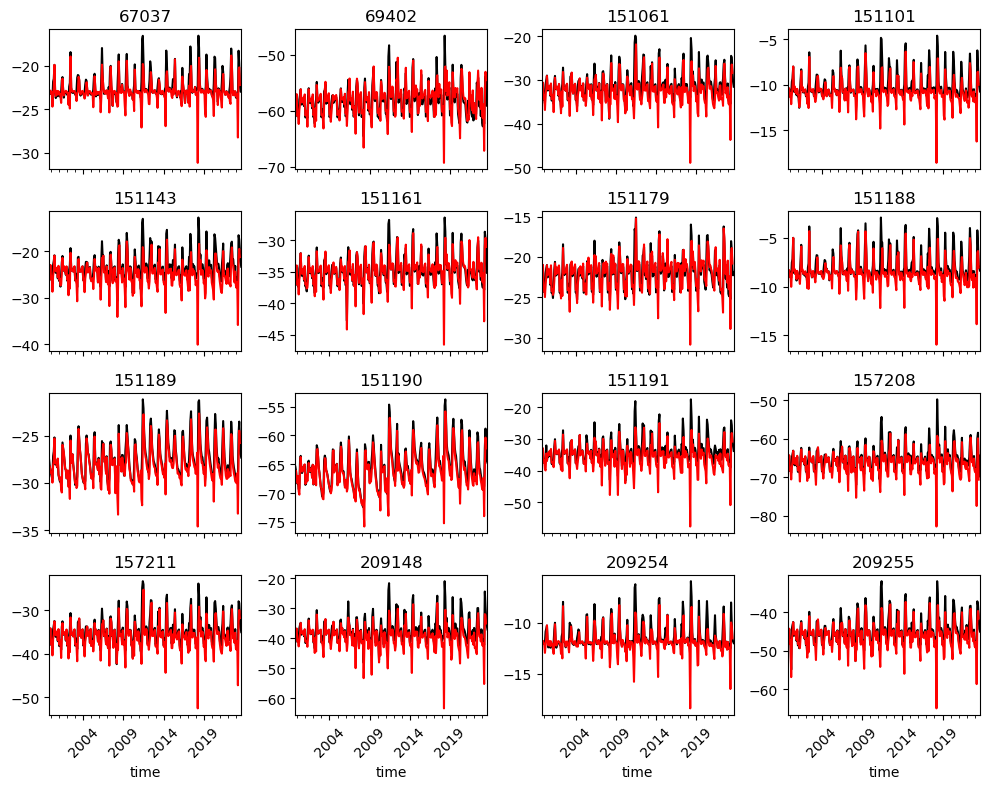

In [29]:
fig, ax = plt.subplots(4, 4, figsize=(10, 8), sharex=True)
for i in range(df_wells2.shape[1]):
    df.iloc[:, i+1].plot(ax=ax[i//4, i%4], color='black', label='Observed GW depth')
    df_corr.iloc[:, i].plot(ax=ax[i//4, i%4], color='red', label='Corrected GW depth')
    ax[i//4, i%4].tick_params(axis='x', rotation=45)
    ax[i//4, i%4].title.set_text(df.columns[i+1])
# ax[3, 5].set_visible(False)
    
plt.tight_layout()
plt.show()

We still do not seem like we are removing the signal. But there does seem to be some interesting patterns. There are consistent big corrections in spring where corrected gw depths are much lower than observed, and there are some smaller, but still significant corrections at peak gw levels (min. depth). Let's see what the trends look like for the corrected depths.  

In [30]:
df_melt = df_corr.dropna().reset_index().melt(id_vars='time')
df_melt['time'] = pd.to_datetime(df_melt['time'])

In [32]:
# Melt dataframe
df_trend = df_melt.copy()
df_trend['timestamp'] = df_trend['time'].apply(lambda x: x.timestamp() if pd.notnull(x) else x)

# Group the data by the 'variable' column and apply the 'get_trend' function
trends = df_trend.groupby('variable').apply(viz.get_mk_trend)

# Join the 'trends' DataFrame with the 'df_trend' DataFrame
df_trend = df_trend.join(trends, on='variable')

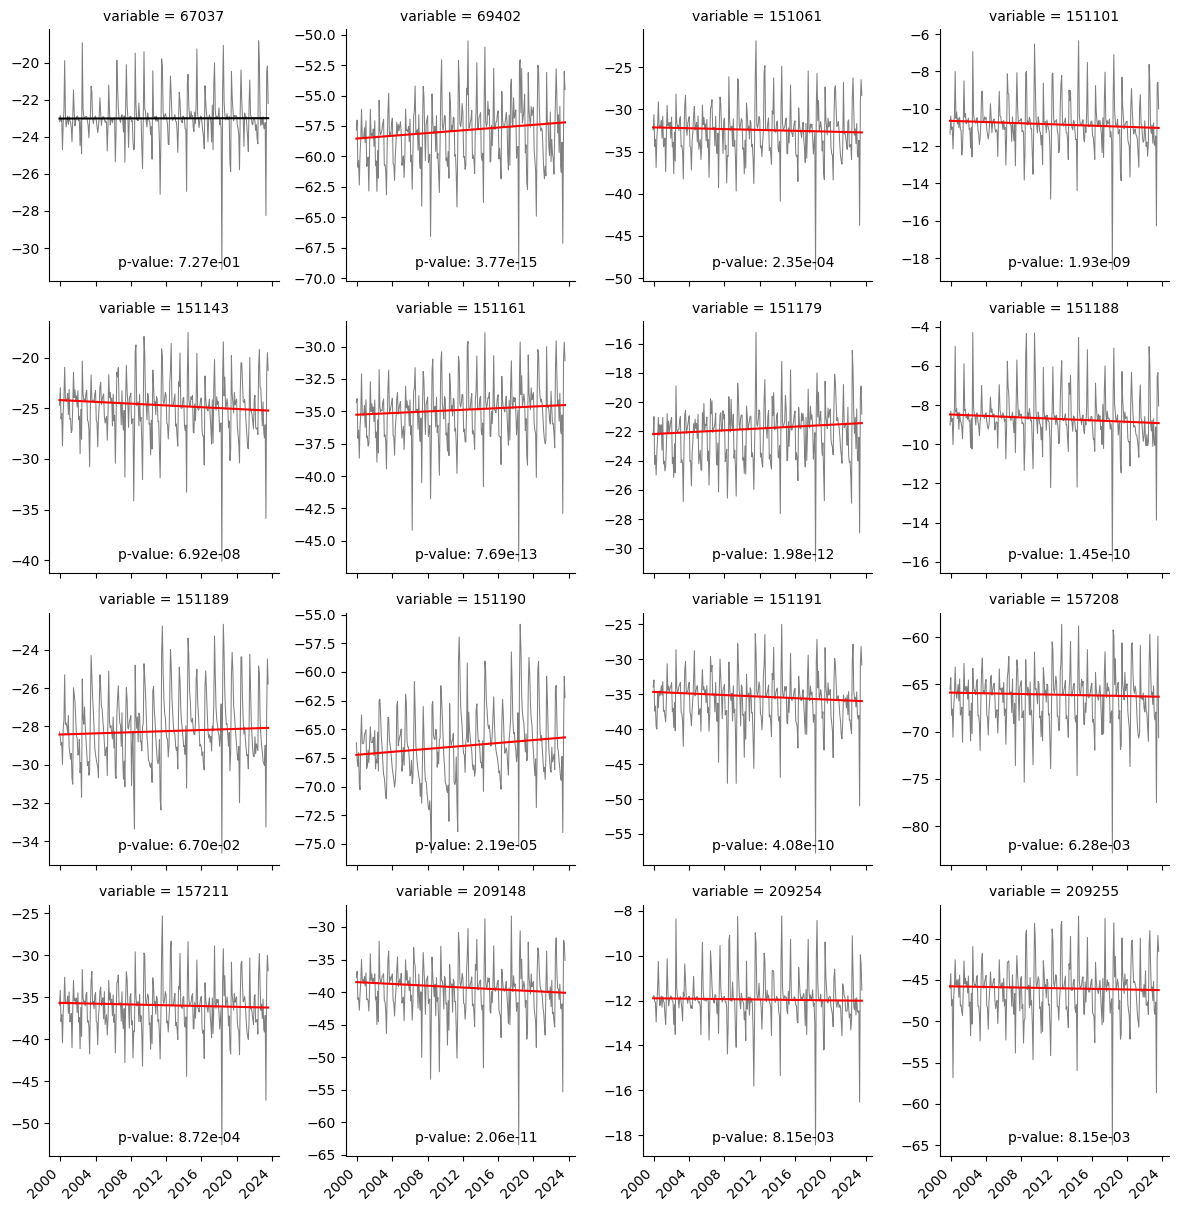

In [33]:
# Create the FacetGrid plot
g = sns.FacetGrid(df_trend, col='variable', col_wrap=4, sharey=False, sharex=True)

# Map the plot_data_and_trendline function to the FacetGrid
g.map_dataframe(viz.plot_data_and_trendline, mann_kendall=True)

# Rotate the x-tick labels on all subplots
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

plt.show()

I am surprised, the correction did not take out many of the trends--with exception to '209254'. Something is off. I will try a different stats library just to make sure there is not a mistake in the code. 

In [34]:
import statsmodels.api as sm

In [35]:
df_corr2 = df.iloc[:, 1:].copy()
for well in range(df_wells2.iloc[:, 1:].shape[1]+1):
    x = df_q.values
    X = sm.add_constant(x)
    y = df_wells2.iloc[:, well].values
    model = sm.OLS(y, X).fit()
    y_pred_sm = model.predict(X)
    y_pred_sm = pd.Series(y_pred_sm, index=df_wells2.index)
    y_corr_sm = df.iloc[:, well+1].sub(y_pred_sm.cumsum())
    df_corr2.iloc[:, well] = y_corr_sm

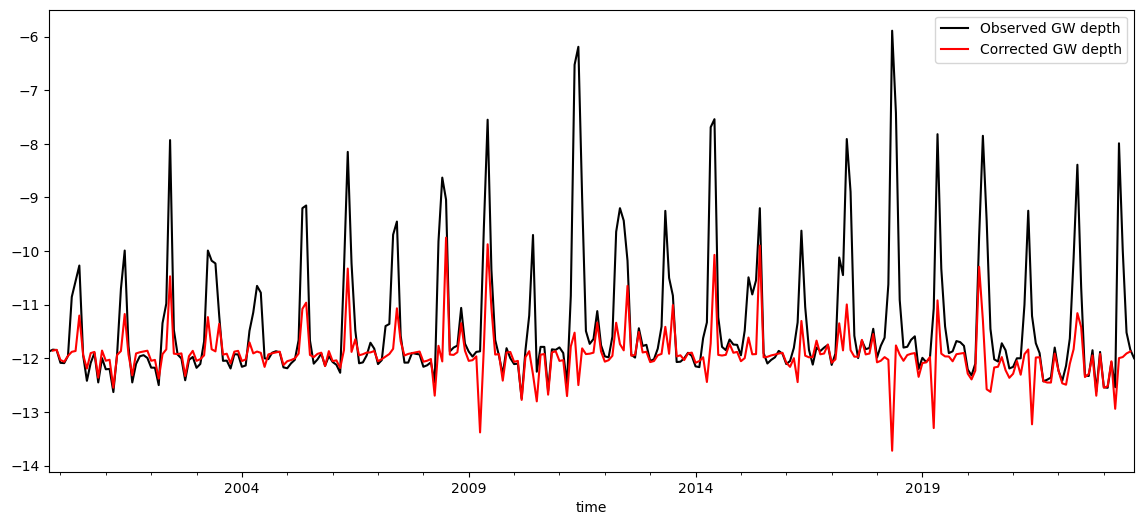

In [36]:
well_id = '209254'
df[well_id].plot(figsize=(14, 6), color='black', label='Observed GW depth')
df_corr2[well_id].plot(figsize=(14, 6), color='red', label='Corrected GW depth')
plt.legend()

This correction is more what I would expect, but it is not consistent across all wells

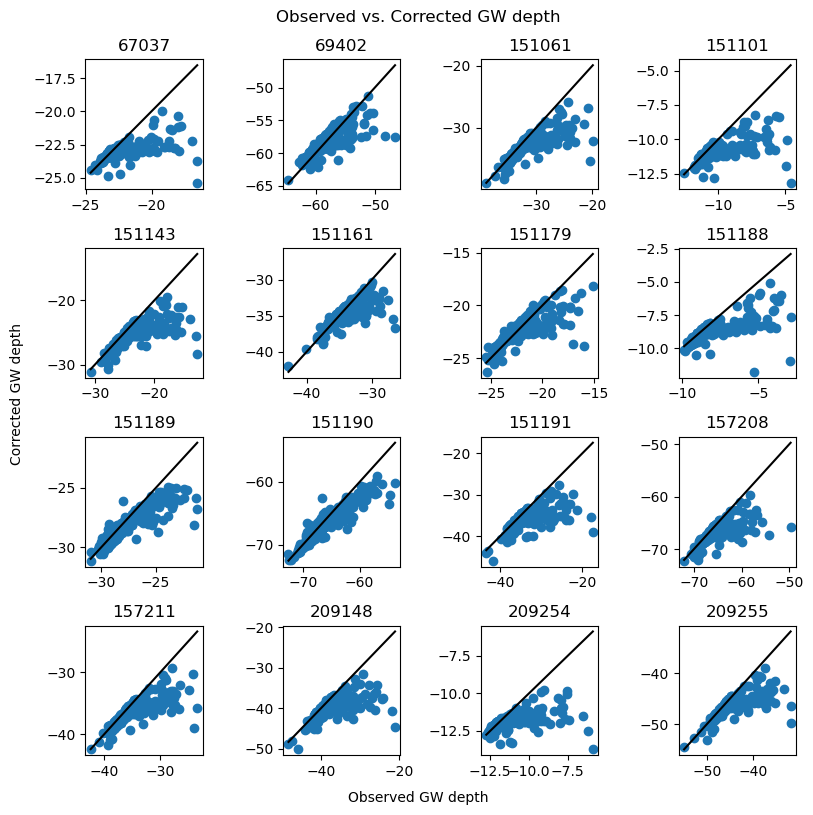

In [37]:
fig, ax = plt.subplots(4, 4, figsize=(8, 8))
for i, well_id in enumerate(df_corr2.columns):
    ax.flatten()[i].plot(df[well_id], df_corr2[well_id], 'o')
    ax.flatten()[i].plot([df[well_id].min(), df[well_id].max()], [df[well_id].min(), df[well_id].max()], 'k-')
    ax.flatten()[i].title.set_text(well_id)
# ax[3, 5].set_visible(False)
fig.suptitle('Observed vs. Corrected GW depth')
fig.text(0.5, -0.01, 'Observed GW depth', ha='center')
fig.text(-0.01, 0.5, 'Corrected GW depth', va='center', rotation='vertical')
plt.tight_layout()
plt.show()

'1509671' is the only one where some corrected values are higher than observed. This is also the only well that has a decreasing trend.

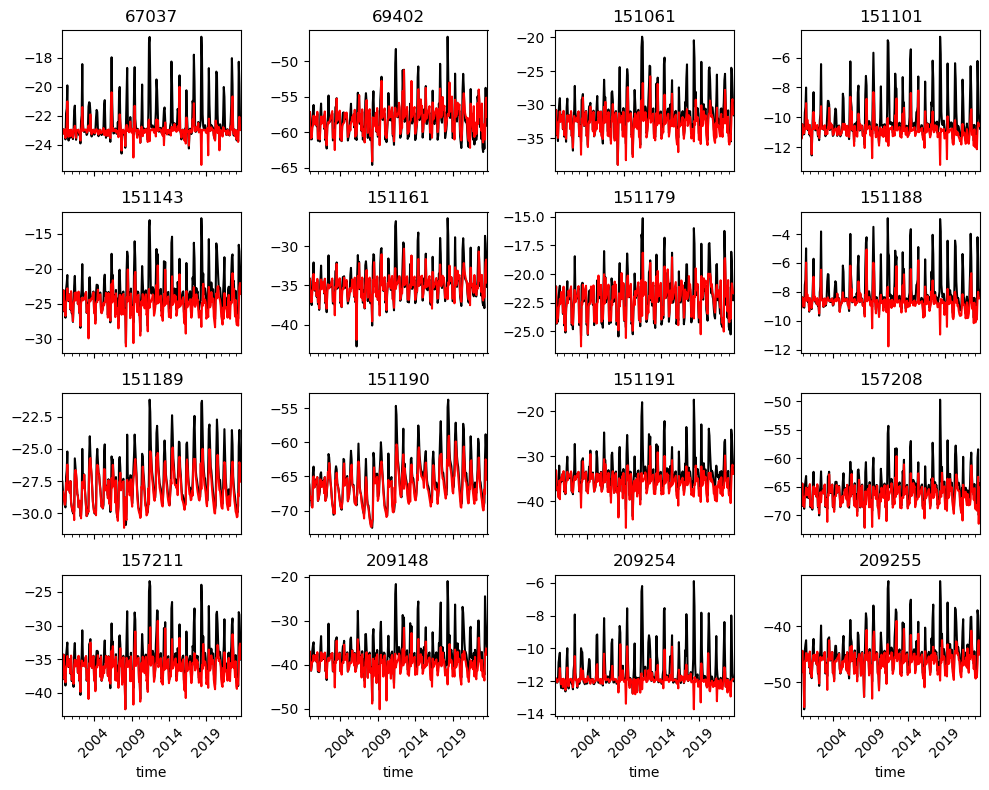

In [38]:
fig, ax = plt.subplots(4, 4, figsize=(10, 8), sharex=True)
for i in range(df_wells2.shape[1]):
    df.iloc[:, i+1].plot(ax=ax[i//4, i%4], color='black', label='Observed GW depth')
    df_corr2.iloc[:, i].plot(ax=ax[i//4, i%4], color='red', label='Corrected GW depth')
    ax[i//4, i%4].tick_params(axis='x', rotation=45)
    ax[i//4, i%4].title.set_text(df.columns[i+1])
# ax[3, 5].set_visible(False)
    
plt.tight_layout()
plt.show()

The correction seems to be stronger using this stats library (I have no idea why they would be any different), but still not as strong as I would expect. Let's look at trends.

In [39]:
# Clip to just last 10 years
# df_corr2 = df_corr2[(df_corr2.index >= '2014-10-01') & (df_corr2.index <= '2023-09-30')]

In [40]:
df_melt2 = df_corr2.dropna().reset_index().melt(id_vars='time')
df_melt2['time'] = pd.to_datetime(df_melt2['time'])

In [41]:
# Melt dataframe
df_trend = df_melt2.copy()
df_trend['timestamp'] = df_trend['time'].apply(lambda x: x.timestamp() if pd.notnull(x) else x)

# Group the data by the 'variable' column and apply the 'get_trend' function
trends = df_trend.groupby('variable').apply(viz.get_mk_trend)

# Join the 'trends' DataFrame with the 'df_trend' DataFrame
df_trend = df_trend.join(trends, on='variable')

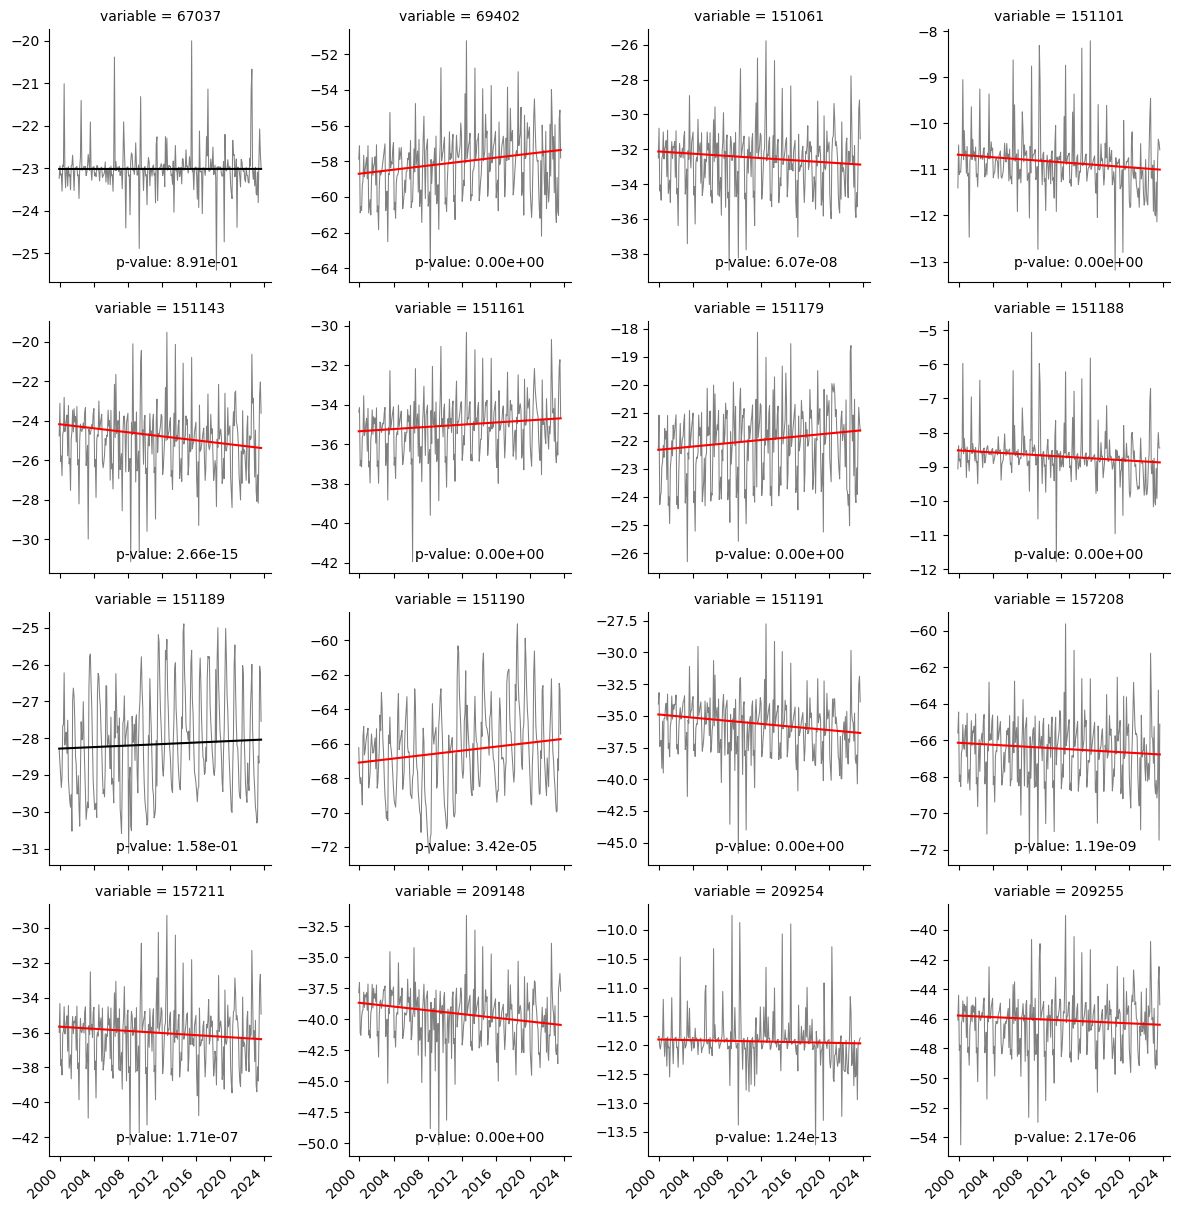

In [42]:
# Create the FacetGrid plot
g = sns.FacetGrid(df_trend, col='variable', col_wrap=4, sharey=False, sharex=True)

# Map the plot_data_and_trendline function to the FacetGrid
g.map_dataframe(viz.plot_data_and_trendline, mann_kendall=True)

# Rotate the x-tick labels on all subplots
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

plt.show()